In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

## Load in data

In [20]:
file_path_trainC = "widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.csv"
train_cat = pd.read_csv(file_path_trainC)

file_path_trainFCM = "widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

file_path_trainQ = "widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv"
train_Quant = pd.read_csv(file_path_trainQ)

file_path_trainS = "widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.csv"
train_Solutions = pd.read_csv(file_path_trainS)
train_Solutions.drop(columns = ['Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [21]:
file_path_testC = "widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

file_path_testFCM = "widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

file_path_testQ = "widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

## Combine train and test categorical data sets in order to get summative one hot encoding

In [22]:
train_cat = train_cat.drop(columns = 'Basic_Demos_Enroll_Year')

In [23]:
train_shape = train_cat.shape

for col in train_cat.select_dtypes(include = 'number').columns:
    train_cat[col] = train_cat[col].astype('Int64')
    train_cat[col] = train_cat[col].astype('category')
    
for col in test_cat.select_dtypes(include = 'number').columns:
    test_cat[col] = test_cat[col].astype('Int64')
    test_cat[col] = test_cat[col].astype('category')
    
cat_train_test = pd.concat([train_cat, test_cat], axis = 0).reset_index(drop = True)
columns_to_encode = cat_train_test.columns[1:].tolist()
cat_train_test_final = cat_train_test.drop(columns = columns_to_encode)

for col in cat_train_test.columns[1:]:
    encoded = pd.get_dummies(cat_train_test[col], prefix = col)
    cat_train_test_final = pd.concat([cat_train_test_final, encoded], axis = 1)

cat_train_test_final.head()

,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023
0,UmrK0vMLopoR,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,CPaeQkhcjg7d,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nb4EetVPm3gs,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,p4vPhVu91o4b,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M09PXs7arQ5E,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split back into training and testing sets and combine with quantitative and FCM data

In [24]:
cat_train_final = cat_train_test_final.iloc[0:train_shape[0]]
cat_test_final = cat_train_test_final.iloc[train_shape[0]:]

In [25]:
logreg_sex = pd.merge(train_FCM, train_Quant, on = 'participant_id')
train_df = pd.merge(cat_train_final, logreg_sex, on = 'participant_id')

# ensure it looks accurate
print(train_df.shape)
train_df.head()

(1213, 19984)


,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,1,0,0,0,0,1,0,0,0,...,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,0,0,1,0,0,0,1,0,0,...,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,1,0,0,0,0,0,1,0,0,...,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,0,0,1,0,0,1,0,0,0,...,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0,0,1,0,0,1,0,0,0,...,1,18,4,11,4,10,7,3,9,8.940679


In [26]:
test_cat_FCM = pd.merge(cat_test_final, test_FCM, on = 'participant_id')
test_df = pd.merge(test_cat_FCM, test_Quant, on = 'participant_id')

# ensure it looks accurate
print(test_df.shape)
test_df.head()

(304, 19984)


,participant_id,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4,Basic_Demos_Study_Site_5,PreInt_Demos_Fam_Child_Ethnicity_0,PreInt_Demos_Fam_Child_Ethnicity_1,PreInt_Demos_Fam_Child_Ethnicity_2,PreInt_Demos_Fam_Child_Ethnicity_3,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0,0,0,1,0,1,0,0,0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0,0,0,1,0,1,0,0,0,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0,0,0,1,0,1,0,0,0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0,0,0,1,0,1,0,0,0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,0,0,0,1,0,0,0,1,0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


## Fill NaN values and missings

In [27]:
print(logreg_sex.isna().sum())

logreg_sex.fillna({'MRI_Track_Age_at_Scan':logreg_sex['MRI_Track_Age_at_Scan'].mean()}, inplace = True)

print(logreg_sex.isna().sum().sum()) # should now be zero

participant_id             0
0throw_1thcolumn           0
0throw_2thcolumn           0
0throw_3thcolumn           0
0throw_4thcolumn           0
                        ... 
SDQ_SDQ_Hyperactivity      0
SDQ_SDQ_Internalizing      0
SDQ_SDQ_Peer_Problems      0
SDQ_SDQ_Prosocial          0
MRI_Track_Age_at_Scan    360
Length: 19919, dtype: int64
0


In [28]:
print(train_df.isna().sum())

train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)

print(train_df.isna().sum().sum()) # should now be zero

participant_id                0
Basic_Demos_Study_Site_1      0
Basic_Demos_Study_Site_2      0
Basic_Demos_Study_Site_3      0
Basic_Demos_Study_Site_4      0
                           ... 
SDQ_SDQ_Hyperactivity         0
SDQ_SDQ_Internalizing         0
SDQ_SDQ_Peer_Problems         0
SDQ_SDQ_Prosocial             0
MRI_Track_Age_at_Scan       360
Length: 19984, dtype: int64
0


## Logistic Regression for Feature Selection

**We will first use L1 regularization with Sex as the target.**

In [29]:
model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model.fit(logreg_sex.drop(columns = ['participant_id']), train_Solutions['Sex_F'])
selected_features_Sex = logreg_sex.drop(columns = ['participant_id']).columns[model.coef_[0] != 0]

**We will now use L1 regularization with ADHD_Outcome as the target**

In [30]:
model = LogisticRegression(penalty = 'l1', solver = 'liblinear')
model.fit(train_df.drop(columns = 'participant_id'), train_Solutions['ADHD_Outcome'])
selected_features_ADHD = train_df.drop(columns = 'participant_id').columns[model.coef_[0] != 0]

## Preparing train and test sets

In [31]:
X_train_adhd = train_df[selected_features_ADHD]
X_train_sex = train_df[selected_features_Sex]
Y_train_adhd = train_Solutions['ADHD_Outcome'].values
Y_train_sex = train_Solutions['Sex_F'].values

In [14]:
# for adhd
x_train_adhd, x_val_adhd, y_train_adhd, y_val_adhd = train_test_split(X_train_adhd, Y_train_adhd, test_size = .2)

# for sex
x_train_sex, x_val_sex, y_train_sex, y_val_sex = train_test_split(X_train_sex, Y_train_sex, test_size = .2)

## Random Forest 

In [15]:
# creating a RF classifier
adhd_forest = RandomForestClassifier(n_estimators = 100, max_depth = 5) 
sex_forest = RandomForestClassifier(n_estimators = 100, max_depth = 5) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
adhd_forest.fit(X_train_adhd, y_train_adhd)
sex_forest.fit(X_train_sex, y_train_sex)

# performing predictions on the test dataset
y_pred_adhd = adhd_forest.predict(X_val_adhd)
y_pred_sex = sex_forest.predict(X_val_sex)

In [16]:
adhd_forest.score(X_val_adhd, y_val_adhd)

0.8148148148148148

In [17]:
sex_forest.score(X_val_sex, y_val_sex)

0.6748971193415638

## Evaluate

In [18]:
cv_scores_adhd = cross_val_score(adhd_forest, X_train_adhd, y_train_adhd, cv = 5)
cv_scores_sex = cross_val_score(sex_forest, X_train_sex, y_train_sex, cv = 5)

# CV for multioutput random forest, partial data for sex, all for adhd
# Cross-validation scores for each fold: [0.72680412 0.71907216 0.70103093 0.71649485 0.68814433]
# Mean CV score: 0.7103092783505154

# CV for separate random forests, adhd, gender
# Cross-validation scores for each fold: [0.80412371 0.77319588 0.80412371 0.80927835 0.84020619]
# Mean CV score: 0.8061855670103093
# Cross-validation scores for each fold: [0.67010309 0.68041237 0.67010309 0.67525773 0.67010309]
# Mean CV score: 0.6731958762886598

print("Cross-validation scores for each fold:", cv_scores_adhd)
print("Mean CV score:", np.mean(cv_scores_adhd))

print("Cross-validation scores for each fold:", cv_scores_sex)
print("Mean CV score:", np.mean(cv_scores_sex))

Cross-validation scores for each fold: [0.76804124 0.85051546 0.77835052 0.81958763 0.7628866 ]
Mean CV score: 0.7958762886597939
Cross-validation scores for each fold: [0.65463918 0.6443299  0.65463918 0.66494845 0.62886598]
Mean CV score: 0.6494845360824743


In [33]:
sex_score = []
adhd_score = []

for i in range(0, 100):
    x_train_adhd, x_val_adhd, y_train_adhd, y_val_adhd = train_test_split(X_train_adhd, Y_train_adhd, test_size = .2)
    x_train_sex, x_val_sex, y_train_sex, y_val_sex = train_test_split(X_train_sex, Y_train_sex, test_size = .2)
    
    adhd_forest = RandomForestClassifier(n_estimators = 100, max_depth = 5) 
    sex_forest = RandomForestClassifier(n_estimators = 100, max_depth = 5) 

    adhd_forest.fit(x_train_adhd, y_train_adhd)
    sex_forest.fit(x_train_sex, y_train_sex)
    
    sex_score.append(sex_forest.score(x_val_sex, y_val_sex))
    adhd_score.append(adhd_forest.score(x_val_adhd, y_val_adhd))

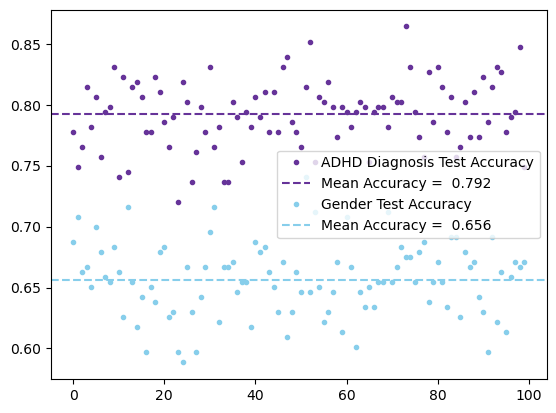

In [34]:
plt.plot(adhd_score, '.', lw = 1, color = 'rebeccapurple', label = 'ADHD Diagnosis Test Accuracy')
plt.axhline(np.mean(adhd_score), color = 'rebeccapurple', ls = '--', label = 'Mean Accuracy = {0: .{1}f}'.format(np.mean(adhd_score), 3))
plt.plot(sex_score, '.', lw = 1, color = 'skyblue', label = 'Gender Test Accuracy')
plt.axhline(y = np.mean(sex_score), color = 'skyblue', ls = '--', label = 'Mean Accuracy = {0: .{1}f}'.format(np.mean(sex_score), 3))

plt.legend()
plt.savefig('twoforest.pdf')
plt.show()